# Quantum Min Cut

Having experimented with the max flow algorithm, as well as finding the minimum cut in Notebook 1 using Google's `ortools` library, we will now attempt to apply this algorithm to the quantum world.

For this purpose, we will use DWave.

In [1]:
# Load Data
import geopandas as gpd

gdf_edges = gpd.read_file("../data/gdf_edges_bi.geojson") # Read bi-directional edges
gdf_nodes = gpd.read_file("../data/gdf_nodes.geojson") # Read nodes

# Important: We found that some nodes are related to itself further down the line in this notebook. We remove them here:

gdf_edges = gdf_edges[~ (gdf_edges.start_node == gdf_edges.end_node)]

From DWave's `dimod` library, we import their binary quadratic model, as well as a solver to solve quadratic equations:.

In the following cell, we merely solve an example quadratic equation: 

$$

E(x,y) = -x -y + 2xy + 0.0

$$

In [2]:
from dimod import ExactSolver, BinaryQuadraticModel

# Create a simple BQM (Binary Quadratic Model)
bqm = BinaryQuadraticModel({'x': -1, 'y': -1}, {('x', 'y'): 2}, 0.0, 'BINARY')

# Use local classical solver
sampler = ExactSolver()
sampleset = sampler.sample(bqm)

print(sampleset)

   x  y energy num_oc.
1  1  0   -1.0       1
3  0  1   -1.0       1
0  0  0    0.0       1
2  1  1    0.0       1
['BINARY', 4 rows, 4 samples, 2 variables]


... and we find that energy is lowest (-1.0) when either $x = 1$ and $y = 0$ or vice versa. This gives us a very simple insight into how quantum annealers find the global minimum energy state when given a binary quadratic problem.

Now, we try to apply this to a more intriguing scenario fitting our case - a graph. Using this approach, we formulate the traversal of the graph as a binary quadratic problem and use a quantum annealer to find the min cut we found in notebook `1-data-preparation`, only this time, we do it using quantum tools.

First, we define a simple, undirected graph:

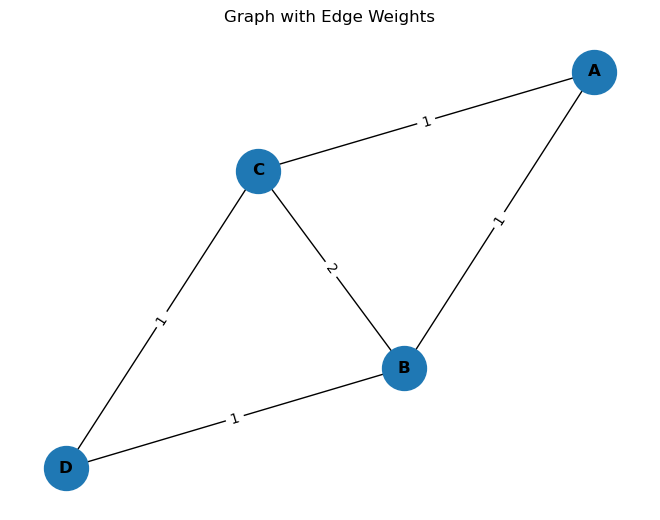

In [3]:
# Define graph edges and weights 
edges = {
    ('A', 'B'): 1,
    ('A', 'C'): 1,
    ('B', 'D'): 1,
    ('C', 'D'): 1,
    ('B', 'C'): 2
}

# Fix node 'A' to source (0) and 'D' to sink (1)
fixed = {'A': 0, 'D': 1}
penalty = 10  # Strong penalty to enforce constraints

import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph
G = nx.Graph()

# Add the edges and weights
for (u, v), w in edges.items():
    G.add_edge(u, v, weight=w)

# Set layout for nodes
pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_size=1000, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): w for (u, v), w in edges.items()})
plt.title("Graph with Edge Weights")
plt.show()

Then, we formulate the problem as a binary quadratic equation. Every edge is formulated as a binary quadratic equation with the weight acting as the penalizer in an optimization problem such that $(u,v) , w $ represents an undirected edge with weight $w$ and the goal is to minimize the cut between source and sink by assigning binary values to nodes — 0 for one side of the cut, 1 for the other — while penalizing edges that cross the cut according to their weights.

In [4]:
# Encode min-cut objective

bqm = BinaryQuadraticModel('BINARY')

for (u, v), w in edges.items():
    bqm.add_quadratic(u, v, -2 * w)
    bqm.add_linear(u, bqm.get_linear(u) + w)
    bqm.add_linear(v, bqm.get_linear(v) + w)

Then, we encode hard constraints to ensure that the source and sink nodes are assigned fixed binary values. This is done by adding a penalty term of the form 

$$ penalty = (x_i - v_i)^2 $$ 

for each fixed node $i$, where $x_i \in {0,1}$ is the binary variable associated with node $i$ and $v_u$ is its prescribed value ($0$ for source, $1$ for sink). A large penalty (e.g., 10) discourages solutions where these nodes are assigned incorrect values.


In [5]:
# Encode fixed node constraints: (x - value)^2 * penalty
for var, value in fixed.items():
    bqm.add_linear(var, bqm.get_linear(var) + penalty * (1-2 * value))
    bqm.offset += penalty * value

And we solve the problem:

In [6]:
from dwave.samplers import SimulatedAnnealingSampler

# Solve using classical simulated annealer
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
best = sampleset.first.sample

# Output partition
print("Min-Cut Partition:")
for node, val in best.items():
    side = "Source side" if val == 0 else "Sink side"
    print(f"  {node}: {side}")

# Output cut edges
cut_edges = [(u, v) for (u, v) in edges if best[u] != best[v]]
print("\nCut Edges:")
for u, v in cut_edges:
    print(f"  {u} — {v}")


Min-Cut Partition:
  A: Source side
  B: Source side
  C: Source side
  D: Sink side

Cut Edges:
  B — D
  C — D


... As such, we can attempt to apply this to our larger graph. We first generalise this approach as a function:

In [7]:
def solve_min_cut(edges, source, sink, penalty=10, num_reads=100):
    """
    Solves the min-cut problem on an undirected graph using a Binary Quadratic Model.

    Parameters:
        edges (dict): Dictionary with edge tuples as keys and weights as values.
        source (str): Node to be fixed to 0 (source side).
        sink (str): Node to be fixed to 1 (sink side).
        penalty (float): Penalty strength for enforcing source/sink constraints.
        num_reads (int): Number of reads for the simulated annealer.

    Returns:
        dict: Best node assignments (0 = source side, 1 = sink side).
        list: List of edges that are part of the min-cut.
    """
    bqm = BinaryQuadraticModel('BINARY')

    # Encode min-cut objective
    for (u, v), w in edges.items():
        bqm.add_quadratic(u, v, -2 * w)
        bqm.add_linear(u, bqm.get_linear(u) + w)
        bqm.add_linear(v, bqm.get_linear(v) + w)

    # Encode fixed node constraints
    fixed = {source: 0, sink: 1}
    for var, value in fixed.items():
        bqm.add_linear(var, bqm.get_linear(var) + penalty * (1 - 2 * value))
        bqm.offset += penalty * (value ** 2)

    # Solve using classical simulated annealer
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    best = sampleset.first.sample

    # Identify cut edges
    cut_edges = [(u, v) for (u, v) in edges if best[u] != best[v]]

    return best, cut_edges

Then, we encode our previous edge set in the necessary format:

In [8]:
edges = {
    (row['start_node'], row['end_node']): row['bandwith']
    for _, row in gdf_edges.iterrows()
}

for edge, weight in list(edges.items())[:5]:
    print(f"{edge}: {weight}")

('node_0000', 'node_0001'): 4534.917302116375
('node_0001', 'node_0002'): 4534.917302116375
('node_0002', 'node_0003'): 4534.917302116375
('node_0003', 'node_0004'): 4534.917302116375
('node_0004', 'node_0005'): 4534.917302116375


And we solve the problem from notebook 1 (finding the minimum cut between NY and Singapore):

In [12]:
best, cut_edges = solve_min_cut(edges, source='node_4442', sink='node_0208', penalty=10)

print("Min-Cut Partition:")
for node, val in list(best.items())[:5]:
    side = "Source side" if val == 0 else "Sink side"
    print(f" {node}: {side}")

print("\nCut Edges:")
for u, v in cut_edges[:5]:
    print(f"  {u} — {v}")


Min-Cut Partition:
 node_0000: Source side
 node_0001: Source side
 node_0002: Source side
 node_0003: Source side
 node_0004: Source side

Cut Edges:


However, we encouter a problem here.... - no edges are cut.